# 一、原理介绍

- 信用评分卡基于对申请人的各项数据进行评估并给出一个分数，定量预测申请人的偿债能力。
- 信用评分卡由一系列特征项组成，开发评分卡系统模型中，首先确定各特征与申请人信用之间的相互关系，
然后为特征分配适当的分数权重，分数权重越大，说明该特征能越好的表现信用。
- 申请人的得分是各项特征属性分值的简单求和，如果申请人的信用评分大于金融放款机构所设定的界限分数，
此申请处于可接受的风险水平并被批准，而低于界限分数的申请人将被拒绝或给予标示以便进一步审查。
- A卡预测的是用户在申请贷款通过以后发生不良行为的概率，因此目标变量就是”贷款正常/出现不良“。
我们一般把目标变量命名为“bad”，如果一条样本的bad等于1，就表示这条样本出现了不良行为，属于“坏”样本；bad等于0，表示这是一条“好”样本。

# 二、项目流程

（1）数据获取。包括获取存量客户及潜在客户的数据；

（2）数据预处理。包括数据清洗、缺失值处理、异常值处理，将原始数据转化为可用作模型开发的格式化数据；

（3）探索性分析。获取样本总体的大概情况，描述样本总体情况的指标主要包括直方图、箱型图等；

（4）变量选择。主要通过统计学方法，筛选出对违约状态影响最显著的特征；

（5）模型开发。包括变量分段，变量的 WOE 变换和逻辑回归估算；

（6）模型评估。评估模型的区分能力、预测能力、稳定性，并形成模型评估报告；

（7）信用评分。根据逻辑回归的系数和 WOE 等确定信用评分方法，将 Logistic 模型转换为标准评分形式；

（8）建立评分系统。根据信用评分方法，建立自动信用评分系统。

# 三、数据处理
## 1. 数据说明
- 数据来源于Kaggle的Give Me Some Credit竞赛项目，其中cs-training.csv文件有15万条的样本数据，包含了11个变量，大致情况如下表所示。

|变量名称|描述|类型
|----|--|----|
|SeriousDlqin2yrs|个人经历了逾90天的拖欠或者更糟的情况（区分好坏客户）|Y/N|
|RevolvingUltilizationOfUnsecuredLines|（信用卡和个人信贷余额的总余额 - 房地产和没有分期付款的债务（如汽车贷款）） / 信贷总限额|percentage|
|age|借款人年龄|integer|
|NumberOfTime30-59DaysPastDueNotWorse|借款人历史有出现30-59天逾期记录的次数，但在过去两年没有更差的信用记录|integer|
|DebRatio|负债比例|percentage|
|MonthlyIncome|月收入|real|
|NumberOfOpenCreditLinesAndLoans|开放贷款的数量和信用额度|integer|
|NumberOfTimes90DaysLate|借款人历史有出现90天或以上的记录的次数|integer|
|NumberRealEstateLoansOrLines|抵押贷款和房地产贷款数量|integer|
|NumberOfTime60-89DaysPastDueNotWorse|借款人历史有出现过60-89天逾期记录的次数，但两年内无更严重逾期|integer|
|NumberOfDependents|家庭中的家属人数|integer|

## 2. 数据导入以及查看

In [1]:
# 加载包
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from pandas import Series
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import warnings
warnings.filterwarnings('ignore')
from sklearn.metrics import roc_curve,auc
import matplotlib
import math
import statsmodels.api as sm

In [2]:
# 导入数据并查看基本信息
data = pd.read_csv('./cs-training.csv')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150000 entries, 0 to 149999
Data columns (total 12 columns):
 #   Column                                Non-Null Count   Dtype  
---  ------                                --------------   -----  
 0   Unnamed: 0                            150000 non-null  int64  
 1   SeriousDlqin2yrs                      150000 non-null  int64  
 2   RevolvingUtilizationOfUnsecuredLines  150000 non-null  float64
 3   age                                   150000 non-null  int64  
 4   NumberOfTime30-59DaysPastDueNotWorse  150000 non-null  int64  
 5   DebtRatio                             150000 non-null  float64
 6   MonthlyIncome                         120269 non-null  float64
 7   NumberOfOpenCreditLinesAndLoans       150000 non-null  int64  
 8   NumberOfTimes90DaysLate               150000 non-null  int64  
 9   NumberRealEstateLoansOrLines          150000 non-null  int64  
 10  NumberOfTime60-89DaysPastDueNotWorse  150000 non-null  int64  
 11  

In [3]:
# 第一列没用，删除之
data = data.iloc[:, 1:]

In [4]:
# 查看缺失值
data.isnull().sum()

SeriousDlqin2yrs                            0
RevolvingUtilizationOfUnsecuredLines        0
age                                         0
NumberOfTime30-59DaysPastDueNotWorse        0
DebtRatio                                   0
MonthlyIncome                           29731
NumberOfOpenCreditLinesAndLoans             0
NumberOfTimes90DaysLate                     0
NumberRealEstateLoansOrLines                0
NumberOfTime60-89DaysPastDueNotWorse        0
NumberOfDependents                       3924
dtype: int64

- 特征量MonthlyIncome缺失数量为29731个，缺失值较多
- 特征量NumberOfDependts缺失为3924个，缺失值较少

## 3. 数据预处理
数据化清洗的“**完全合一**”规则：

1. **完**整性：单条数据是否存在空值，统计的字段是否完善。（data.isnull().sum()）
2. **全**面性：观察某一列的全部数值，比如在 Excel 表中，我们选中一列，可以看到该列的平均值、最大值、最小值。
我们可以通过常识来判断该列是否有问题，比如：数据定义、单位标识、数值本身。（data.info() / data.describe() / data.describe(include = 'O')）
3. **合**法性：数据的类型、内容、大小的合法性。比如数据中存在非 ASCII 字符，性别存在了未知，年龄超过了 150 岁等。（data.boxplot()）
4. 唯**一**性：数据是否存在重复记录，因为数据通常来自不同渠道的汇总，重复的情况是常见的。
行数据、列数据都需要是唯一的，比如一个人不能重复记录多次，且一个人的体重也不能在列指标中重复记录多次。（data.drop_duplicates()）

### (1) 缺失值处理

信用风险评分模型开发首要步骤就是处理缺失值：
- 直接删除含缺失值的样本
- 根据样本之间相似性填补缺失值
- 根据变量之间的相关性填补缺失值

特征量 MonthlyIncome 缺失值较多，此处采用随机森林方法进行填补。

In [5]:
# 定义填补函数
def set_missing(df):
    '''
    df : 需要填补的 DataFrame
    :return df : 返回已修补好的 DataFrame
    '''
    # 重新采集特殊值的顺序，未用到 NumberOfDependents， 应是与月收入无关。
    process_df = data.iloc[:, [5,0,1,2,3,4,6,7,8,9]]
    # 分成 未缺失组 和 缺失组 两个组，前者用于训练模型，后者用于预测结果。values 函数，将 DF 转换为矩阵
    known = process_df[process_df['MonthlyIncome'].notnull()].values
    unknown = process_df[process_df['MonthlyIncome'].isnull()].values
    # x 为特征属性，未取 MonthlyIncome， 因为其为预测值。X 即为 feature。
    X = known[:, 1:]
    # Y 为结果标签值,即 target
    Y = known[:, 0]
    rfr = RandomForestRegressor(random_state = 0, n_estimators = 200, max_depth = 3, n_jobs = -1)
    # 用 未缺失组 数据（120269条）去建模，预测缺失组的 MonthlyIncome 值。
    rfr.fit(X, Y)
    predicted = rfr.predict(unknown[:, 1:]).round(0)
    # 用得到的预测结果填补原始缺失数据
    df.loc[(df['MonthlyIncome'].isnull()), 'MonthlyIncome'] = predicted
    print("完成 MonthlyIncome 列数据填充。")
    return df

In [6]:
data = set_missing(data)

完成 MonthlyIncome 列数据填充。


特征量 NumberOfDependts 缺失值较少（3924条），直接删除有缺失值的样本。

In [7]:
data = data.dropna()
data = data.drop_duplicates()
data.to_csv('MissingData.csv', index = False)
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 145563 entries, 0 to 149999
Data columns (total 11 columns):
 #   Column                                Non-Null Count   Dtype  
---  ------                                --------------   -----  
 0   SeriousDlqin2yrs                      145563 non-null  int64  
 1   RevolvingUtilizationOfUnsecuredLines  145563 non-null  float64
 2   age                                   145563 non-null  int64  
 3   NumberOfTime30-59DaysPastDueNotWorse  145563 non-null  int64  
 4   DebtRatio                             145563 non-null  float64
 5   MonthlyIncome                         145563 non-null  float64
 6   NumberOfOpenCreditLinesAndLoans       145563 non-null  int64  
 7   NumberOfTimes90DaysLate               145563 non-null  int64  
 8   NumberRealEstateLoansOrLines          145563 non-null  int64  
 9   NumberOfTime60-89DaysPastDueNotWorse  145563 non-null  int64  
 10  NumberOfDependents                    145563 non-null  float64
dtype

经过填补和删除缺失值后，所有特征的数据量都为145563。

### （2） 异常值处理
异常值是指明显偏离大多数抽样数据的数值，比如客户的年龄大于100或小于0时，通常认为该值为异常值。
在统计学中，常把低于 Q1-1.5IQR 的值和高于 Q3+1.5IQR 的值作为异常值。通过绘制箱型图能很明显的看到异常值。

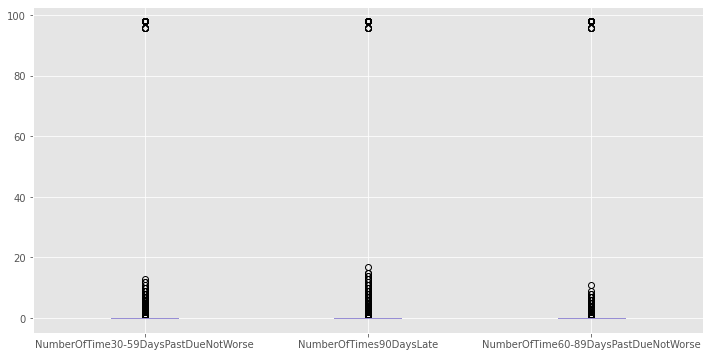

In [8]:
# 选择 'NumberOfTime30-59DaysPastDueNotWorse'、'NumberOfTimes90DaysLate'、'NumberOfTime60-89DaysPastDueNotWorse'做箱线图
plt.figure(figsize=(12, 6))
plt.style.use('ggplot')
data_box = data.iloc[:, [3, 7, 9]]
data_box.boxplot()
plt.show()

在这三个特征之中有两组样本偏离了其他样本的分布，可以将其去除

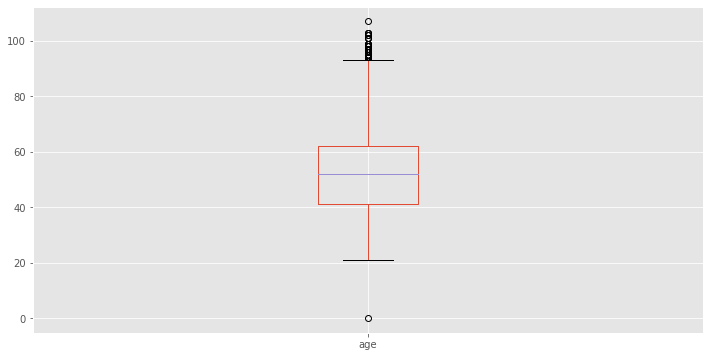

In [9]:
# 年龄箱线图
# series类型
data_age = data['age']
# dataframe类型
data_age = data[['age']]
plt.figure(figsize=(12, 6))
data_age.boxplot()
plt.show()

- age为0的样本，明显是不符合常识的，应同样作为异常值舍弃,剔除age为0的样本；
- 剔除变量 NumberOfTime30-59DaysPastDueNotWorse、NumberOfTimes90DaysLate、NumberOfTime60-89DaysPastDueNotWorse的异常值，
剔除其中一个变量的96、98值，其他变量的96、98两个值也会相应被剔除

In [10]:
# 剔除异常值
data = data[data['age'] > 0]
data = data[data['NumberOfTime30-59DaysPastDueNotWorse'] < 90]

- 至此，data 中的总条数为145354条。
- 数据集中好客户为0，违约客户为1，考虑到正常的理解，能正常履约并支付利息的客户为1，所以我们将其取反。
- 转换后，1代表优质用户；0代表劣质用户。

In [11]:
# 1代表好客户；0代表坏客户。
data['SeriousDlqin2yrs'] = 1 - data['SeriousDlqin2yrs']

### （3）数据切分
为了验证模型的拟合效果，需要对数据集进行切分，分成训练集和测试集：
训练集用于训练模型，得出模型参数；测试集用于检验模型的拟合能力，防止过拟合或欠拟合。

In [12]:
Y = data['SeriousDlqin2yrs']
X = data.iloc[:, 1:]

In [13]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.3, random_state = 0)
# 将训练集中的 X 和 Y 在列的方向上合并。训练集数据共 101747 条（145354*0.7=101747.8）。
train = pd.concat([Y_train, X_train], axis = 1)
test = pd.concat([Y_test, X_test], axis = 1)
train.to_csv('TrainData.csv',index = False)
test.to_csv('TestData.csv',index = False)

## 4. 探索性分析
- 在建立模型之前，我们一般会对现有的数据进行探索性数据分析（Exploratory Data Analysis）。
- EDA是指对已有的数据(特别是调查或观察得来的原始数据)在尽量少的先验假定下进行探索。
- 常用的探索性数据分析方法有：直方图、散点图和箱线图等。
例如，以下对特征量年龄和月收入进行分析：

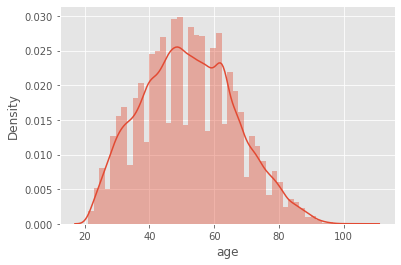

In [14]:
# 对年龄进行分析
age = data['age']
sns.distplot(age)
plt.show()

- 年龄的分布大致呈正态分布，符合统计分析假设。

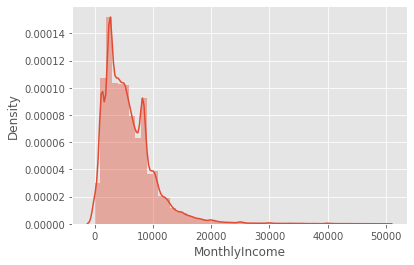

In [15]:
# 对MonthlyIncome进行分析，为了使图形更直观，将x轴范围设置在50000以内
mi = data[data['MonthlyIncome'] < 50000]['MonthlyIncome']
sns.distplot(mi)
plt.show()

- 月收入的分布大致呈正态分布，符合统计分析假设。

# 四、变量选择
特征变量选择(排序)决定了模型性能，正确的选择特征变量能够帮助理解数据特点、底层结构，对进一步改善模型、算法均有重要作用。
在本文采用通过 WOE 分析方法选择信用评分模型的变量，即通过比较指标分箱和对应分箱的违约概率来确定指标是否符合经济意义。

## 1. 分箱处理（变量离散化）

变量分箱是对连续变量进行离散化，即将连续变量划分为若干个区间，每个区间赋予相同的值。这句话可以拆解为三个问题。
- 首先，为什么要离散化？
离散化最重要的作用是增加模型的鲁棒性，提高模型的泛化能力。连续型变量往往内部存在异常值，通过变量分箱可以消除异常值的干扰。
而且变量分箱可以把缺失值划为单独的类进行处理，降低了缺失值对模型的影响。
- 其次，若干个区间该怎么划分？业界常用的方法是卡方分箱和决策树分箱。
- 最后，分箱后每个区间该赋什么值？在这里需要掌握两个概念，WOE值和IV值。

信用评分卡开发一般常用的分箱方法为等距分段、等深分段、最优分段。
- 等距分段（Equval length intervals）是指分段的区间是一致的，比如年龄以十年作为一个分段；
- 等深分段（Equal frequency intervals）是先确定分段数量，然后令每个分段中数据数量大致相等；
- 最优分段（Optimal Binning）又叫监督离散化（supervised discretizaion），使用递归划分（Recursive Partitioning）将连续变量分为分段，背后是一种基于条件推断查找较佳分组的算法。

首先选择对连续变量进行最优分段，在连续变量的分布不满足最优分段的要求时，再考虑对连续变量进行等距分段。


#### WOE（Weight of Evidence）

<img src="https://pic1.zhimg.com/v2-2a30371de0b521d94072d67543114086_720w.jpg?source=d16d100b" data-caption="" data-size="normal" data-rawwidth="363" data-rawheight="97" class="content_image" width="363">

- 用笔者自己编造出来的术语来说，这东西就是单变量某个取值的“含1率”。
p(y=1|x=i)越高，x的取值i对应的WOE就越大，说明x的这个取值i使样本的y取值更偏向于1。
- WOE是自变量取某个值的时候对违约比例的一种影响，分箱过程中同时计算了证据权重WOE和信息价值IV(Information Value)，前者在建立逻辑回归模型时需要将所有的变量转为WOE，而后者则可以很好的展示变量的预测能力。
- WOE值计算完成以后，会按照分箱的区间，对原始数据进行赋值。比如“年龄”变量有一个箱是[25,30)，WOE值是0.015。那么年龄符合这一区间的所有样本的年龄取值都转化为0.015。
- WoE的数学定义是:woe=ln(goodattribute/badattribute)。goodattribute计算方式是每个箱子里的好客户数量/数据集里总的好客户数量；badattribute计算方式是每个箱子里的坏客户数量/数据集里总的坏客户数量。
- 不同的特征，最优分箱后产生不同的箱子个数，每一个区间对应一个woe值。最后得到的woex1是列表中存放着x1特征分箱后所有的woe。
- 最终，训练模型时使用的自变量数据都是WOE化后的数据，不使用原始数据。
---
#### IV（Information Value）


- 它其实是单变量所有WOE取值的加权平均，用来衡量这个变量整体的预测能力，或者说“区分度”。IV值越大，则变量的区分效果越好。

<img src="https://pic1.zhimg.com/v2-f6b53e90980b84a5c17cf16e68dd95e8_720w.png?source=d16d100b" data-caption="" data-size="normal" data-rawwidth="640" data-rawheight="94" class="origin_image zh-lightbox-thumb" width="640" data-original="https://pic1.zhimg.com/v2-f6b53e90980b84a5c17cf16e68dd95e8_720w.jpg?source=d16d100b">

- 注意，WOE对应的是单变量的某一个取值，IV对应的是单变量的整体。

- IV一般用于变量筛选。IV值过低的变量不具有区分能力，还可能对模型产生干扰，应该予以舍弃。
正常情况下，IV在0.1到0.5之间的变量都可以先加入模型。
IV过高并不是好事，需要警惕。它说明这个变量对y的区分度极好。很有可能它是滞后变量。

使用最优分段对于数据集中的连续变量进行分类。
- RevolvingUtilizationOfUnsecuredLines
- age
- DebtRatio
- MonthlyIncome




- r: 这个相关系数在-1和+1之间变化，0表示没有相关性。相关系数的绝对值约接近1，相关性越高。
- p: p值粗略地表示不相关系统产生具有Spearman相关性的数据集的概率（通俗的说，就是2个变量不相关的概率，总体上，若2个变量的相关系数越高，则P值会相对较低）。
p值并不完全可靠，但对于大于500左右的数据集可能是合理的。
- r表示相关系数，p表示不相关的概率，r与p相当于一个互补的关系，相关系数越大，不相关的概率就越小


In [16]:
def mono_bin(Y, X, n = 20):
    '''
    Y : train['SeriousDlqin2yrs']
    X : train['feature']
    n : 初始分箱数量
    :return
    d4 : 某特征值各分箱区间的参数，df类型。
    iv : 信息价值。一个特征值仅有一个值，用来后续模型筛选特征值使用。
    woe : 权重，list类型。后续要把该分箱下所有数据，转变为对应特征值的 woe。
    cut : 最终分箱结果，list类型 ：[-inf, a, b, c, d, inf]。
    '''
    good = Y.sum() # 好用户数量：94934
    bad = Y.count() - good # 坏用户数量：50420
    r = 0
    while np.abs(r) < 1:
        # 形成一个DF。第一列：欲分箱的特征值；第二列：好坏标志；第三列：分箱后的区间结果。
        d1 = pd.DataFrame({'X': X, 'Y': Y, 'Bucket':pd.qcut(X, n)})
        # 按分箱后的区间进行聚合
        d2 = d1.groupby(['Bucket'], as_index = True)
        # 使用斯皮尔曼等级相关系数来评估两个变量之间的相关性
        # r 为相关系数； p 为概率；p 越小，表示越相关。
        r, p = stats.spearmanr(d2['X'].mean(), d2['Y'].mean())
        n = n - 1
    d3 = pd.DataFrame()
    # 因 d2 是分组后聚合的结果。因此，d2['X].min()会返回整个分箱的结果
    d3['min'] = d2['X'].min()
    d3['max'] = d2['X'].max()
    d3['sum'] = d2['Y'].sum() # 每个分箱中的好用户数
    d3['total'] = d2['Y'].count()  # 每个分箱中的总用户数
    d3['rate'] = d2['Y'].mean()   # d3['rate'] = d3['sum'] / d3['total']
    d3['goodattribute'] = d3['sum'] / good # 每个分箱中，好用户数量 / 总体好用户数（整体合计数）
    d3['badattribute'] = (d3['total'] - d3['sum']) / bad # 每个分箱中，坏用户数量 / 总体坏用户数（整体合计数）
    d3['woe'] = np.log(d3['goodattribute'] / d3['badattribute']) # 计算各分箱的 woe 值
    iv = ((d3['goodattribute'] - d3['badattribute']) * d3['woe']).sum() # 计算特征值的 iv 值, iv 是求和后的结果。
    d4 = (d3.sort_values(by = 'min'))
    woe = list(d4['woe'].values) # 转换为 list 格式
    print(d4) # 输出该特征值下分箱各参数
    print('-' * 30)
    # 以下函数返回具体分箱
    cut = []
    cut.append(float('-inf'))
    for i in range(1,n+1):
        qua = X.quantile(i/(n+1)) # quantile求分位数，pos = (n+1)*p，n为数据的总个数，p为0-1之间的值
        cut.append(round(qua,4)) # round()方法返回浮点数x的四舍五入值。
    cut.append(float('inf'))
    return d4,iv,woe,cut

In [17]:
dfx1,ivx1,woex1,cutx1 = mono_bin(train['SeriousDlqin2yrs'],train['RevolvingUtilizationOfUnsecuredLines'],n = 10) 
dfx2,ivx2,woex2,cutx2 = mono_bin(train['SeriousDlqin2yrs'],train['age'],n = 20)
dfx4,ivx4,woex4,cutx4 = mono_bin(train['SeriousDlqin2yrs'],train['DebtRatio'],n = 10)
dfx5,ivx5,woex5,cutx5 = mono_bin(train['SeriousDlqin2yrs'],train['MonthlyIncome'],n = 10)

                       min           max    sum  total      rate  \
Bucket                                                             
(-0.001, 0.0312]  0.000000      0.031215  24941  25437  0.980501   
(0.0312, 0.158]   0.031218      0.157927  24895  25437  0.978692   
(0.158, 0.558]    0.157928      0.558119  24149  25436  0.949402   
(0.558, 50708.0]  0.558127  50708.000000  20949  25437  0.823564   

                  goodattribute  badattribute       woe  
Bucket                                                   
(-0.001, 0.0312]       0.262719      0.072802  1.283343  
(0.0312, 0.158]        0.262235      0.079554  1.192807  
(0.158, 0.558]         0.254377      0.188904  0.297580  
(0.558, 50708.0]       0.220669      0.658741 -1.093666  
------------------------------
                min  max   sum  total      rate  goodattribute  badattribute  \
Bucket                                                                         
(20.999, 31.0]   21   31  7468   8393  0.889789     

其他离散变量无法使用最优分箱，使用人工选择的方式进行:
- NumberOfTime30-59DaysPastDueNotWorse
- NumberOfOpenCreditLinesAndLoans
- NumberOfTimes90DaysLate
- NumberRealEstateLoansOrLines
- NumberOfTime60-89DaysPastDueNotWorse
- NumberOfDependents

In [18]:
def self_bin(Y,X,cat):
    '''
    :param Y: train['SeriousDlqin2yrs']
    :param X: train['feature']
    :param cat: 人工分箱参数，为 list 类型。
    :return: d4:某特征值各分箱区间的参数，df类型；iv:信息价值；woe:权重数。
    '''
    good = Y.sum()
    bad = Y.count() - good
    d1 = pd.DataFrame({'X': X, 'Y': Y, 'Bucket': pd.cut(X, cat)}) # pd.cut():使用自定义的区间进行分箱。
    d2 = d1.groupby(['Bucket'], as_index=True)
    d3 = pd.DataFrame(d2['X'].min(),columns=['min'])
    d3['min'] = d2['X'].min()
    d3['max'] = d2['X'].max()
    d3['sum'] = d2['Y'].sum()
    d3['total'] = d2['Y'].count()
    d3['rate'] = d2['Y'].mean()
    d3['goodattribute'] = d3['sum'] / good
    d3['badattribute'] = (d3['total'] - d3['sum']) / bad
    d3['woe'] = np.log(d3['goodattribute'] / d3['badattribute'])
    iv = ((d3['goodattribute'] - d3['badattribute']) * d3['woe']).sum()
    d4 = d3.sort_values(by = 'min')
    print(d4)
    print('-' * 30)
    woe = list(d3['woe'].values)
    return d4,iv,woe

In [19]:
ninf = float('-inf')
pinf = float('inf')
cutx3 = [ninf,0,1,3,5,pinf]
cutx6 = [ninf,1,2,3,5,pinf]
cutx7 = [ninf,0,1,3,5,pinf]
cutx8 = [ninf,0,1,2,3,pinf]
cutx9 = [ninf,0,1,3,pinf]
cutx10 = [ninf,0,1,2,3,5,pinf]

In [20]:
dfx3,ivx3,woex3 = self_bin(train['SeriousDlqin2yrs'],train['NumberOfTime30-59DaysPastDueNotWorse'],cutx3)
dfx6,ivx6,woex6 = self_bin(train['SeriousDlqin2yrs'],train['NumberOfOpenCreditLinesAndLoans'],cutx6)
dfx7,ivx7,woex7 = self_bin(train['SeriousDlqin2yrs'],train['NumberOfTimes90DaysLate'],cutx7)
dfx8,ivx8,woex8 = self_bin(train['SeriousDlqin2yrs'],train['NumberRealEstateLoansOrLines'],cutx8)
dfx9,ivx9,woex9 = self_bin(train['SeriousDlqin2yrs'],train['NumberOfTime60-89DaysPastDueNotWorse'],cutx9)
dfx10,ivx10,woex10 = self_bin(train['SeriousDlqin2yrs'],train['NumberOfDependents'],cutx10)

             min  max    sum  total      rate  goodattribute  badattribute  \
Bucket                                                                       
(-inf, 0.0]    0    0  81862  85334  0.959313       0.862304      0.509614   
(0.0, 1.0]     1    1   9467  11139  0.849897       0.099722      0.245413   
(1.0, 3.0]     2    3   3102   4363  0.710979       0.032675      0.185087   
(3.0, 5.0]     4    5    416    733  0.567531       0.004382      0.046529   
(5.0, inf]     6   13     87    178  0.488764       0.000916      0.013357   

                  woe  
Bucket                 
(-inf, 0.0]  0.525955  
(0.0, 1.0]  -0.900558  
(1.0, 3.0]  -1.734207  
(3.0, 5.0]  -2.362566  
(5.0, inf]  -2.679301  
------------------------------
             min  max    sum  total      rate  goodattribute  badattribute  \
Bucket                                                                       
(-inf, 1.0]    0    1   3048   3661  0.832559       0.032107      0.089975   
(1.0, 2.0]     2    

## 2. 变量相关性分析

- 用经过清洗后的数据查看变量间的相关性。相关程度用相关系数r表示，-1≤r<1，r的绝对值越大，表示变量之间的相关程度越高，r为负数时，表示一个变量的增加可能引起另一个变量的减少，此时，叫做负相关。

- 注意：相关性分析只是初步的检查，检查模型的VI（证据权重）作为变量筛选的依据

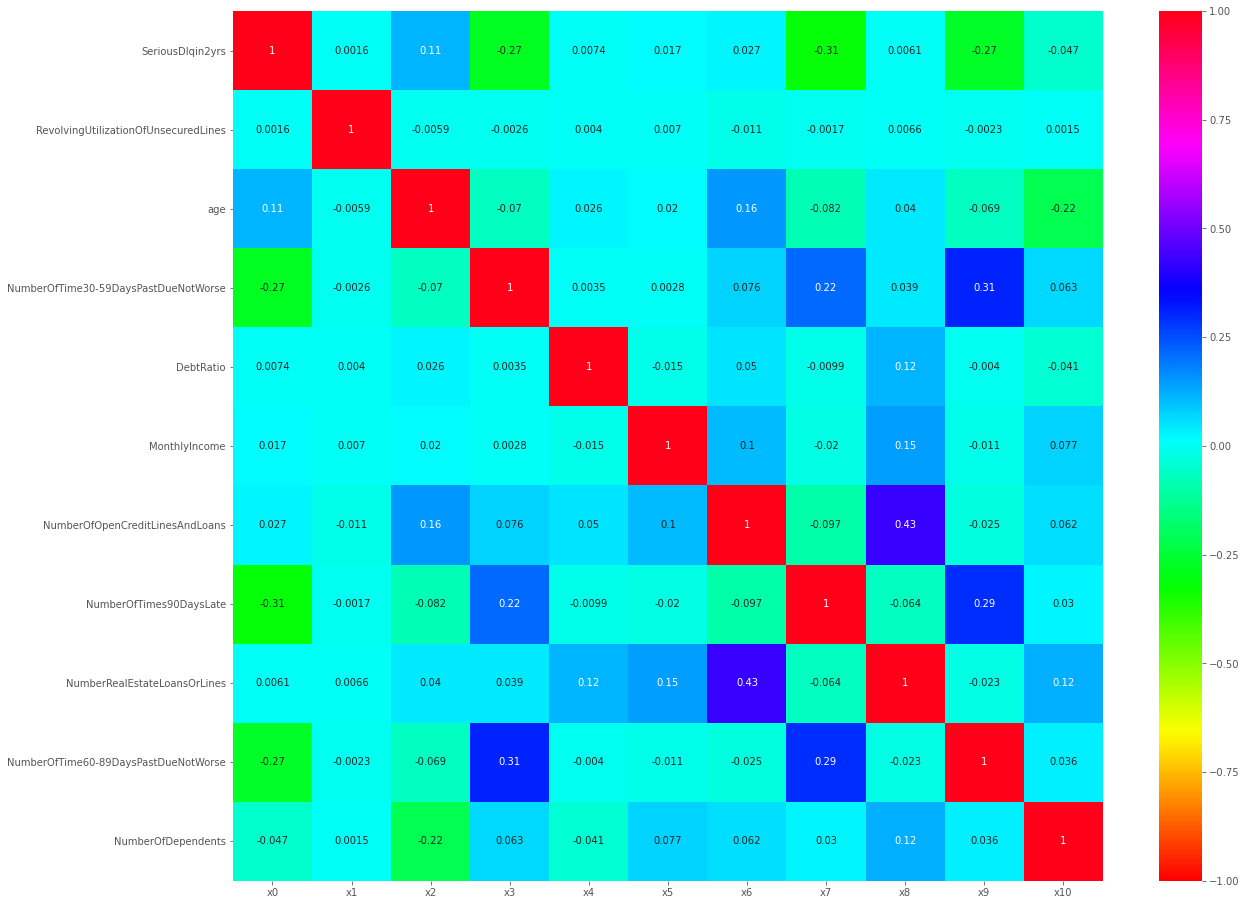

In [21]:
corr = data.corr()
xticks = ['x0','x1','x2','x3','x4','x5','x6','x7','x8','x9','x10']
yticks = list(corr.index) # y轴标签
fig = plt.figure()
fig.set_size_inches(20,16)
ax1 = fig.add_subplot(111)
# 默认是0到1，vmin和vmax可自定义设置
sns.heatmap(corr,vmin=-1,vmax=1,cmap='hsv',annot=True,square=True)
ax1.set_xticklabels(xticks,rotation=0)
ax1.set_yticklabels(yticks,rotation=0)
plt.show()

- 各自变量之间的相关性是非常小的，不存在多重共线性问题，如果存在多重共线性，即有可能存在两个变量高度相关，需要降维或剔除处理.
- NumberOfTime30-59DaysPastDueNotWorse，NumberOfTimes90DaysLate、NumberOfTime60-89DaysPastDueNotWorse这三个特征对于所要预测的值SeriousDlqin2yrs(因变量)有较强的相关性。

## 3. IV筛选

- 建模之前需要先检验变量之间的相关性，如果自变量之间具有强相关性，则会影响模型的准确性；
- 如果自变量和因变量之间具有强相关性，则需要重点关注，后续提取特征时需要保留。

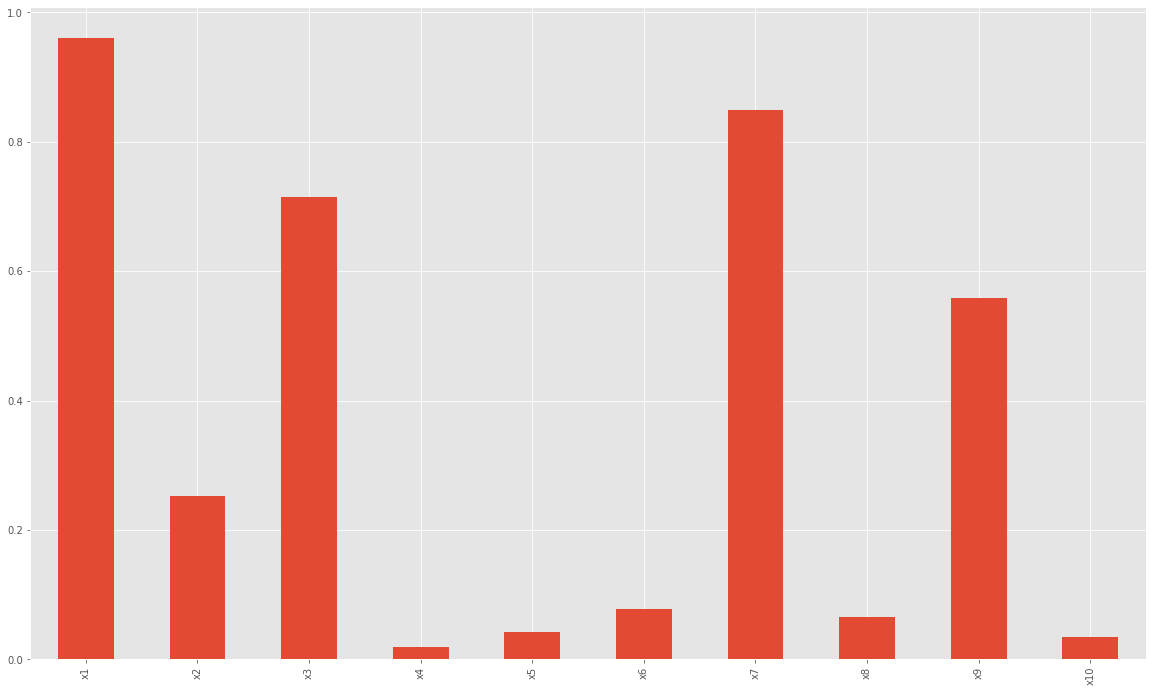

In [22]:
# ivx 为某特征对应的信息价值，是一个数字，值越大，表示对结果影响越大，作为筛选的变量进行后续使用。
ivall = pd.Series([ivx1,ivx2,ivx3,ivx4,ivx5,ivx6,ivx7,ivx8,ivx9,ivx10],
                  index = ['x1','x2','x3','x4','x5','x6','x7','x8','x9','x10'])
fig = plt.figure(figsize=(20,12))
ax1 = fig.add_subplot(111)
ivall.plot(kind='bar',ax = ax1)
plt.show()

- 根据上图，筛选 x1 、 x2 、 x3、 x7、 x9 作为特征值。
- DebtRatio、MonthlyIncome、NumberOfOpenCreditLinesAndLoans、NumberRealEstateLoansOrLines、NumberOfDependents变量的IV值明显较低，预测能力差，所以删除

# 五、模型分析

- 证据权重（Weight of Evidence,WOE）转换可以将 Logistic 回归模型转变为标准评分卡格式，在建立模型之前需要将筛选后的变量转换为 WoE值 ，便于信用评分。

- WOE 转换的目的是为了剔除一些变量，原因或者是因为它们不能增加模型值，或者是因为与其模型相关系数有关的误差较大。

- 建立标准信用评分卡也可以不采用 WOE转换，但 Logistic 回归模型需要处理更大数量的自变量，尽管这样会增加建模程序的复杂性，但最终得到的评分卡都是一样的。

## 1. WOE 转换
- 根据之前分箱结果进行 woe 值替换，并将转化结果构造出模型的训练集，即将选取的特征 woe化 并舍弃不需要的特征，仅保留 woe 转码后的变量。

In [23]:
# WOE转换，
def replace_woe(series,cut,woe):
    '''
    该函数将不同特征值的每条数据，转化为对应分箱区间的 woe 值，用转换后的 woe 值进行模型训练。
    :param series: 要进行 woe 转换的特征值，train['feature']。
    :param cut: 该特征值最后的分箱结果，为 list 类型。
    :param woe: 该特征值分箱后，每个分箱区间对应的 woe 值。
    :return: list:返回转换后的结果。
    '''
    list = []
    i = 0
    while i<len(series):
        value = series[i]
        j = len(cut) - 2
        m = len(cut) - 2
        while j >= 0:
            if value >= cut[j]:
                j = -1
            else:
                j -= 1
                m -= 1
        list.append(woe[m])
        i += 1
    return list

In [24]:
train = pd.read_csv('TrainData.csv')

In [25]:
# 将10个特征值，都进行了转换。
train['RevolvingUtilizationOfUnsecuredLines'] = Series(replace_woe(train['RevolvingUtilizationOfUnsecuredLines'],cutx1,woex1))
train['age'] = Series(replace_woe(train['age'], cutx2, woex2))
train['NumberOfTime30-59DaysPastDueNotWorse'] = Series(replace_woe(train['NumberOfTime30-59DaysPastDueNotWorse'], cutx3, woex3))
train['DebtRatio'] = Series(replace_woe(train['DebtRatio'], cutx4, woex4))
train['MonthlyIncome'] = Series(replace_woe(train['MonthlyIncome'], cutx5, woex5))
train['NumberOfOpenCreditLinesAndLoans'] = Series(replace_woe(train['NumberOfOpenCreditLinesAndLoans'], cutx6, woex6))
train['NumberOfTimes90DaysLate'] = Series(replace_woe(train['NumberOfTimes90DaysLate'], cutx7, woex7))
train['NumberRealEstateLoansOrLines'] = Series(replace_woe(train['NumberRealEstateLoansOrLines'], cutx8, woex8))
train['NumberOfTime60-89DaysPastDueNotWorse'] = Series(replace_woe(train['NumberOfTime60-89DaysPastDueNotWorse'], cutx9, woex9))
train['NumberOfDependents'] = Series(replace_woe(train['NumberOfDependents'], cutx10, woex10))
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101747 entries, 0 to 101746
Data columns (total 11 columns):
 #   Column                                Non-Null Count   Dtype  
---  ------                                --------------   -----  
 0   SeriousDlqin2yrs                      101747 non-null  int64  
 1   RevolvingUtilizationOfUnsecuredLines  101747 non-null  float64
 2   age                                   101747 non-null  float64
 3   NumberOfTime30-59DaysPastDueNotWorse  101747 non-null  float64
 4   DebtRatio                             101747 non-null  float64
 5   MonthlyIncome                         101747 non-null  float64
 6   NumberOfOpenCreditLinesAndLoans       101747 non-null  float64
 7   NumberOfTimes90DaysLate               101747 non-null  float64
 8   NumberRealEstateLoansOrLines          101747 non-null  float64
 9   NumberOfTime60-89DaysPastDueNotWorse  101747 non-null  float64
 10  NumberOfDependents                    101747 non-null  float64
dtype

In [26]:
test = pd.read_csv('TestData.csv')

In [27]:
test['RevolvingUtilizationOfUnsecuredLines'] = Series(replace_woe(test['RevolvingUtilizationOfUnsecuredLines'], cutx1, woex1))
test['age'] = Series(replace_woe(test['age'], cutx2, woex2))
test['NumberOfTime30-59DaysPastDueNotWorse'] = Series(replace_woe(test['NumberOfTime30-59DaysPastDueNotWorse'], cutx3, woex3))
test['DebtRatio'] = Series(replace_woe(test['DebtRatio'], cutx4, woex4))
test['MonthlyIncome'] = Series(replace_woe(test['MonthlyIncome'], cutx5, woex5))
test['NumberOfOpenCreditLinesAndLoans'] = Series(replace_woe(test['NumberOfOpenCreditLinesAndLoans'], cutx6, woex6))
test['NumberOfTimes90DaysLate'] = Series(replace_woe(test['NumberOfTimes90DaysLate'], cutx7, woex7))
test['NumberRealEstateLoansOrLines'] = Series(replace_woe(test['NumberRealEstateLoansOrLines'], cutx8, woex8))
test['NumberOfTime60-89DaysPastDueNotWorse'] = Series(replace_woe(test['NumberOfTime60-89DaysPastDueNotWorse'], cutx9, woex9))
test['NumberOfDependents'] = Series(replace_woe(test['NumberOfDependents'], cutx10, woex10))
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43607 entries, 0 to 43606
Data columns (total 11 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   SeriousDlqin2yrs                      43607 non-null  int64  
 1   RevolvingUtilizationOfUnsecuredLines  43607 non-null  float64
 2   age                                   43607 non-null  float64
 3   NumberOfTime30-59DaysPastDueNotWorse  43607 non-null  float64
 4   DebtRatio                             43607 non-null  float64
 5   MonthlyIncome                         43607 non-null  float64
 6   NumberOfOpenCreditLinesAndLoans       43607 non-null  float64
 7   NumberOfTimes90DaysLate               43607 non-null  float64
 8   NumberRealEstateLoansOrLines          43607 non-null  float64
 9   NumberOfTime60-89DaysPastDueNotWorse  43607 non-null  float64
 10  NumberOfDependents                    43607 non-null  float64
dtypes: float64(10),

## 2 Logistic模型建立

woe值替换之后选取特征量x1、x2、x3、x7、x9进行模型训练：
在算法选择方面，我们通常使用二分类逻辑回归。逻辑回归的好处是可以输出概率值，这个概率值可以通过一定的运算转化为评分卡分数。

In [28]:
# Logistic模型建立

Y = train['SeriousDlqin2yrs']
X = train.drop(['SeriousDlqin2yrs','DebtRatio','MonthlyIncome', 'NumberOfOpenCreditLinesAndLoans','NumberRealEstateLoansOrLines','NumberOfDependents'],axis=1)
# 是给X1加上了一列常数列，该列值均为1。加1是因为该模型是一条直线，其在y轴上是有截距的，这个常数1最终会反映出这个截距。
X1 = sm.add_constant(X)
logit = sm.Logit(Y,X1)
result = logit.fit()
print(result.summary())

Optimization terminated successfully.
         Current function value: 0.186784
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:       SeriousDlqin2yrs   No. Observations:               101747
Model:                          Logit   Df Residuals:                   101741
Method:                           MLE   Df Model:                            5
Date:                Thu, 25 May 2023   Pseudo R-squ.:                  0.2398
Time:                        14:09:26   Log-Likelihood:                -19005.
converged:                       True   LL-Null:                       -25000.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                           coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------
const                                    9.7360      0.1

- statsmodels是python用于线性回归的包，统计学中常用，sklearn中也有很多关于线性回归的包比如linear_model中就有，lasso，ridge，logistics回归等，但是sklearn中的包的可视化相对较差，statsmodels的可视化就比较好。

Logit模型的相关拟合结果。结果包含两部分：
- 上半部分给出了和模型整体相关的信息，包括因变量的名称（Dep. Variable: Purchased）、模型名称（Model: Logit）、拟合方法（Method: MLE 最大似然估计）等信息；
- 下半部分则给出了和每一个系数相关的信息，包括系数的估计值（coef）、标准误（std err）、z统计量的值、显著水平（P>|z|）和95%置信区间。


- coef: 系数的估计值。
- std err: 反映了系数的精度水平。它越低，准确度就越高。
- t：t统计量的值。这是衡量系数在统计上有多重要的一种方法。
- P>|z| : 是你的假定值。p值小于0.05被认为有统计学意义。
- [0.025, 0.975]: 置信区间 。

- 逻辑回归各变量都已通过显著性检验，满足要求

## 3 模型验证

- 导入测试集的数据测试模型，通过 ROC 曲线和 AUC 来评估模型的拟合能力。
- 训练集的数据用于训练模型。测试集的数据用来评估模型的拟合能力。

#### TPR - 真阳性率
- TPR ： 真实的正例中，被预测正确的比例。

#### FPR - 假阳性率
- FPR ： 真实的反例中，被预测错误的比例。

#### 理想的分类器
- 最理想的分类器，就是对样本分类完全正确，即 FP = 0， FN = 0。所以理想分类器 TPR = 1, FPR = 0。

- Y_test 代表测试集中样本的真实结果。 resu 代表逻辑回归预测器预测出来的结果，是一个概率值，代表 “好客户” 的概率。
我们需要设定一个阈值，去判断预测结果正确与否，因此会对应得到不同阈值下的 TPR 和 FPR。
将 resu 中的每个概率值都作为一个阈值，遍历所有的阈值后，得到 ROC 曲线。

#### ROC 曲线

- Receiver Operating Characteristic Curve（受试者特征曲线）。

#### AUC ： 即Area Under Curve（ROC曲线下的面积）

AUC值为ROC曲线所覆盖的区域面积，显然，AUC越大，分类器分类效果越好。
- AUC = 1，是完美分类器，采用这个预测模型时，不管设定什么阈值都能得出完美预测。绝大多数预测的场合，不存在完美分类器。
- 0.5 < AUC < 1，优于随机猜测。这个分类器（模型）妥善设定阈值的话，能有预测价值。
- AUC = 0.5，跟随机猜测一样（例：丢铜板），模型没有预测价值。
- AUC < 0.5，比随机猜测还差；但只要总是反预测而行，就优于随机猜测。


- AUC 常常被用来作为模型排序好坏的指标，原因在于 AUC 可以看做随机从正负样本中选取一对正负样本，其中正样本的得分大于负样本（负样本的Score小于阈值）的概率。
举例：一个正样本，一个负样本，模型预测出正样本的 Score 为 a% ，负样本为 b%，且阈值在ab之间，AUC为a大于b的概率，此概率即为预测正确的概率。
AUC 值越大，当前分类算法越有可能将正样本排在负样本前面，从而能够更好地正确分类。


#### 实际阈值选择与场景有关
- 一般来讲，如果一个点越接近左上角，那么说明模型的预测效果越好。如果能达到左上角点(0,1)，那就是最完美的结果了。

在实际应用中选取最佳阈值的时候，还需要考虑对真阳性的要求以及对假阳性的容忍程度。

- 比如，在一些病毒检测实验中，要求能够识别出所有的真阳性、可以容忍一定程度的假阳性（宁可错杀三千，不可放过一个）——此时阈值0.1是最佳选择。

- 如果不能容忍假阳性、要求识别出来的样本必须为真阳性——此时0.9是最佳阈值。

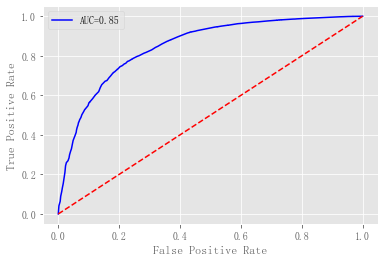

In [29]:
# 模型验证
matplotlib.rcParams['font.sans-serif'] = ['FangSong']
matplotlib.rcParams['axes.unicode_minus'] = False

Y_test = test['SeriousDlqin2yrs']
X_test=test.drop(['SeriousDlqin2yrs','DebtRatio','MonthlyIncome', 'NumberOfOpenCreditLinesAndLoans','NumberRealEstateLoansOrLines','NumberOfDependents'],axis=1)

# 通过 ROC曲线 和 AUC 评估模型的拟合能力
X2 = sm.add_constant(X_test)
# resu 为预测结果
resu = result.predict(X2)
# Y_test 真实结果； resu 是预测结果，结果为概率值，0-1之间，表示为 好用户的 的概率是多少。
# 返回的三个结果均为 numpy.ndarray 格式。 shape : (820,) (820,) (820,)
fpr,tpr,threshold = roc_curve(Y_test,resu)
# 计算 AUC 值
rocauc = auc(fpr,tpr)
plt.plot(fpr,tpr,'b',label = 'AUC=%0.2f' % rocauc)
plt.legend(loc='best')
plt.plot([0,1],[0,1],'r--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

- AUC值为0.85，说明模型的预测能力较好，正确率较高。证明了用当前这五个特征构成信用评分卡的一部分分值是有效的，预测能力较好。

## 4. 信用评分卡构建




![RUNOOB 图标](https://pic3.zhimg.com/80/v2-5e557a0358bc547d101be5e45bba39b6_720w.webp)



![RUNOOB 图标](https://pic2.zhimg.com/80/v2-5a7eadcad4e7b07b0de96dfe8fe18a6d_720w.webp)


![RUNOOB 图标](https://pic2.zhimg.com/80/v2-583c79e2b139f51db40aebf78c9d6379_720w.webp)



建立标准评分卡之前需要选取几个评分卡参数：
- b ：取600；
- o ： 取20；
- p ： 取20；
- factor ： 比例因子；
- offset ： 基础分数


- 个人总评分= 基础分 + 各部分得分

In [50]:
# 计算各个属性的分数
# 每个属性对应的分值： * woe * 比例因子
def get_score(coe,woe,p):
    '''
    coe : 某特征值的回归系数, 对应一个值。
    woe : 某特征值不同分箱区间的 woe 值
    p : 比例因子，此项目计算 p = 28.85
    ---
    return  scores : 返回某特征值的分数列表，不同分箱区间的分数不同。如 RevolvingUtilizationOfUnsecuredLines 特征值的 scores 为[24.0, 22.0, 5.0, -20.0]。
    '''
    scores = []
    for w in woe:
        score = round(coe * w * p,0)
        scores.append(score)
    return scores

In [51]:
# 计算总评分
def compute_score(series,cut,scores):
    '''
    series : test['feature']
    cut : 某特征值对应分箱的最后结果，如：[-inf, a, b, c, inf]
    scores : 某特征值的分数列表，不同分箱区间的分数不同。
    ---
    retrun list : 返回的是某特征值的最终得分。
    '''
    i = 0
    list = []
    while i<len(series):
        value = series[i]
        j = len(cut) - 2
        m = len(cut) - 2
        # 依次判断某特征值的各个值属于哪个分箱区间，对应赋值相应分数。
        while j >= 0:
            if value>=cut[j]:
                j = -1
            else:
                j = j-1
                m = m-1
        list.append(scores[m])
        i = i + 1
    return list

In [52]:
# 回归系数
coe=[9.738849,0.638002,0.505995,1.032246,1.790041,1.131956]
# p值（比例因子），此处计算 p = 28.85
p = 20 / math.log(2) 
# q值，等于 offset， 此处计算 q = 513.56
q = 600 - 20 * math.log(20) / math.log(2)
# 基础分 basescore 计算为 795
basescore = round(q + p * coe[0],0)

# coe 列表第一个是常数项。构建评分卡时候需要选出那些IV值高的特征就行，最后相加得到总分
x1 = get_score(coe[1],woex1,p)
x2 = get_score(coe[2],woex2,p)
x3 = get_score(coe[3],woex3,p)
x7 = get_score(coe[4],woex7,p)
x9 = get_score(coe[5],woex9,p)
# x1的四个值分别对应cut的四个区间.PDO Point Dounble Odds,就是好坏比翻一倍，odds就是好坏比
print("基础分:", basescore)
print("可用额度比值对应的分数:{}".format(x1))
print("年龄对应的分数:{}".format(x2))
print("逾期30-59天笔数对应的分数:{}".format(x3))
print("逾期90天笔数对应的分数:{}".format(x7))
print("逾期60-89天笔数对应的分数:{}".format(x9))

基础分: 795.0
可用额度比值对应的分数:[24.0, 22.0, 5.0, -20.0]
年龄对应的分数:[-8.0, -7.0, -5.0, -5.0, -3.0, -3.0, -2.0, -1.0, 3.0, 5.0, 9.0, 12.0, 15.0, 18.0]
逾期30-59天笔数对应的分数:[16.0, -27.0, -52.0, -70.0, -80.0]
逾期90天笔数对应的分数:[20.0, -102.0, -142.0, -166.0, -160.0]
逾期60-89天笔数对应的分数:[9.0, -60.0, -88.0, -95.0]


In [53]:
test1 = pd.read_csv('TestData.csv')

In [54]:
# BaseScore 列为基础分数列，均为 795
test1['BaseScore'] = Series(np.zeros(len(test1)) + basescore)
test1['x1'] = Series(compute_score(test1['RevolvingUtilizationOfUnsecuredLines'],cutx1,x1))
test1['x2'] = Series(compute_score(test1['age'], cutx2, x2))
test1['x3'] = Series(compute_score(test1['NumberOfTime30-59DaysPastDueNotWorse'], cutx3, x3))
test1['x7'] = Series(compute_score(test1['NumberOfTimes90DaysLate'], cutx7, x7))
test1['x9'] = Series(compute_score(test1['NumberOfTime60-89DaysPastDueNotWorse'], cutx9, x9))
# 'score'列代表最终的分数，为基础分数 + 各特征值对应的分数。
test1['score']= test1['BaseScore']+test1['x1']+test1['x2']+test1['x3']+test1['x7']+test1['x9']
test1.to_csv('scoredata.csv')

In [55]:
print(test1.loc[:,['SeriousDlqin2yrs','BaseScore','x1','x2','x3','x7','x9','score']].head())

   SeriousDlqin2yrs  BaseScore    x1    x2    x3     x7    x9  score
0                 1      795.0 -20.0  -5.0 -70.0 -142.0 -60.0  498.0
1                 1      795.0  22.0   5.0 -27.0 -102.0 -60.0  633.0
2                 1      795.0   5.0  -3.0 -27.0 -102.0 -60.0  608.0
3                 1      795.0  24.0  12.0 -27.0 -102.0 -60.0  642.0
4                 1      795.0  24.0  -5.0 -27.0 -102.0 -60.0  625.0


# 六、总结

挖掘分析kaggle上的数据Give Me Some Credit，结合信用评分卡的建立原理，
通过数据预处理、变量选择、建模分析预测等方法，使用了随机森林算法拟合了缺失值，
使用pandas包对数据进行了清理，并使用matplotlib、seaborn包将数据可视化，
且使用了Logistic回归模型，最后利用模型验证过的部分特征，创建了一个简单的信用评分系统。